In [1]:
infectivity_gain_lower = 1.05
infectivity_gain_upper = 1.4

In [2]:
# ----------------------
# Load required packages
# ----------------------

import json
import random
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
# ---------
# Load data
# ---------

# Contact matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False, plot=False)
# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)  

# Load samples dictionary of the second wave, 3 prevention parameters
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_4_prev_full_2020-12-15_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

In [4]:
# ----------------------------------
# Time-dependant parameter functions
# ----------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)

def report6_policy_function(t, param, l , tau, prev_home, prev_schools, prev_work, prev_rest,scenario='1'):
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define key policy dates
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2020-12-24')
    t10 = pd.Timestamp('2020-12-26')
    t11 = pd.Timestamp('2020-12-31')
    t12 = pd.Timestamp('2021-01-01')
    t13 = pd.Timestamp('2020-01-04') # Opening of schools
    t14 = pd.Timestamp('2021-01-18') # start of alternative policies
    t15 = pd.Timestamp('2021-02-15') # Start of spring break
    t16 = pd.Timestamp('2021-02-21') # End of spring break

    # Average out september mobility
    if t5 <= t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t9:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    else:
        # Scenario 1: Current contact behaviour + schools open on January 18th
        if scenario == '1':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=1)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                                    
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=1)
        # Scenario 2: increases in work or leisure mobility
        elif scenario == '2a':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t14:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t14 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')  
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0,SB='2a')                                                    
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
        elif scenario == '2b':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t14:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t14 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, prev_work, 1, 
                                school=0.6,SB='2b')   
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, prev_work, 1, 
                                school=0,SB='2b')                                                                
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, prev_work, 1, 
                                school=0.6,SB='2b')
        elif scenario == '2c':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t14:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t14 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, prev_rest, 
                                school=0.6,SB='2c')
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, prev_rest, 
                                school=0,SB='2c')                                                
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, prev_rest, 
                                school=0.6,SB='2c')            
        # Scenario 3: Christmas mentality change
        elif scenario == '3':
            if t9 < t <= t10:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t10 < t <= t11:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t11 < t <= t12:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t12 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t14:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=1)
            elif t14 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                                                                    
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=1)


In [5]:
# ------------------------
# Define sampling function
# ------------------------

def draw_fcn(param_dict,samples_dict,to_sample):
    # Sample
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['tau'] = samples_dict['tau'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx] 
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    param_dict['K'] = np.random.uniform(infectivity_gain_lower,infectivity_gain_upper) #infectivity gain
    return param_dict

In [6]:
# --------------------
# Initialize the model
# --------------------

# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Add the time-dependant parameter function arguments
params.update({'l' : 5,
            'tau' : 5,
            'prev_home': 0.5,
            'prev_schools': 0.5,
            'prev_work': 0.5,
            'prev_rest': 0.5,
            'scenario':'1',
            's': np.ones(9)})

initial_states.update({'alpha':np.zeros(9)})

# Initialize
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': report6_policy_function})

In [7]:
# ---------------------------
# Simulate model untill today
# ---------------------------
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15'
warmup = 0
n_samples = 50
n_draws_per_sample = 1000
conf_int = 0.05
# Upper- and lower confidence level
UL = 1-conf_int/2
LL = conf_int/2
out = model.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [8]:
time = out["time"].values
alpha = out['alpha'].mean(dim="Nc").values

In [9]:
# ---------------------------------
# Sample from binomial distribution
# ---------------------------------

H_in = out["H_in"].sum(dim="Nc").values
H_tot = out["H_tot"].sum(dim="Nc").values
# Initialize vectors
H_in_new = np.zeros((H_in.shape[1],n_draws_per_sample*n_samples))
H_tot_new = np.zeros((H_in.shape[1],n_draws_per_sample*n_samples))
# Loop over dimension draws
for n in range(H_in.shape[0]):
    binomial_draw = np.random.poisson( np.expand_dims(H_in[n,:],axis=1),size = (H_in.shape[1],n_draws_per_sample))
    H_in_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    binomial_draw = np.random.poisson( np.expand_dims(H_tot[n,:],axis=1),size = (H_tot.shape[1],n_draws_per_sample))
    H_tot_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
# Compute mean and median
H_in_mean = np.mean(H_in_new,axis=1)
H_in_median = np.median(H_in_new,axis=1)
H_tot_mean = np.mean(H_tot_new,axis=1)
H_tot_median = np.median(H_tot_new,axis=1)
# Compute quantiles
H_in_LL = np.quantile(H_in_new, q = LL, axis = 1)
H_in_UL = np.quantile(H_in_new, q = UL, axis = 1)
H_tot_LL = np.quantile(H_tot_new, q = LL, axis = 1)
H_tot_UL = np.quantile(H_tot_new, q = UL, axis = 1)

In [10]:
# Average and pass on state variables
initial_states = out.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states['alpha'].values = 0.0005*np.ones(9)
# Re-Initialize
model2 = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': report6_policy_function})

In [11]:
# --------------
# Simulate model
# --------------
start_sim2 = '2021-01-15'
end_sim2 = '2021-05-01'
out = model2.sim(end_sim2,start_date=start_sim2,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [12]:
# ---------------------------------
# Sample from binomial distribution
# ---------------------------------

H_in = out["H_in"].sum(dim="Nc").values
H_tot = out["H_tot"].sum(dim="Nc").values
# Initialize vectors
H_in_new = np.zeros((H_in.shape[1],n_draws_per_sample*n_samples))
H_tot_new = np.zeros((H_in.shape[1],n_draws_per_sample*n_samples))
# Loop over dimension draws
for n in range(H_in.shape[0]):
    binomial_draw = np.random.poisson( np.expand_dims(H_in[n,:],axis=1),size = (H_in.shape[1],n_draws_per_sample))
    H_in_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    binomial_draw = np.random.poisson( np.expand_dims(H_tot[n,:],axis=1),size = (H_tot.shape[1],n_draws_per_sample))
    H_tot_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
# Compute mean and median
H_in_mean = np.append(H_in_mean,np.mean(H_in_new,axis=1))
H_in_median = np.append(H_in_median,np.median(H_in_new,axis=1))
H_tot_mean = np.append(H_tot_mean,np.mean(H_tot_new,axis=1))
H_tot_median = np.append(H_tot_median,np.median(H_tot_new,axis=1))
# Compute quantiles
H_in_LL = np.append(H_in_LL,np.quantile(H_in_new, q = LL, axis = 1))
H_in_UL = np.append(H_in_UL,np.quantile(H_in_new, q = UL, axis = 1))
H_tot_LL = np.append(H_tot_LL,np.quantile(H_tot_new, q = LL, axis = 1))
H_tot_UL = np.append(H_tot_UL,np.quantile(H_tot_new, q = UL, axis = 1))

In [13]:
time = np.append(time, out['time'].values)
alpha = np.append(alpha,out['alpha'].mean(dim="Nc").values,axis=1)

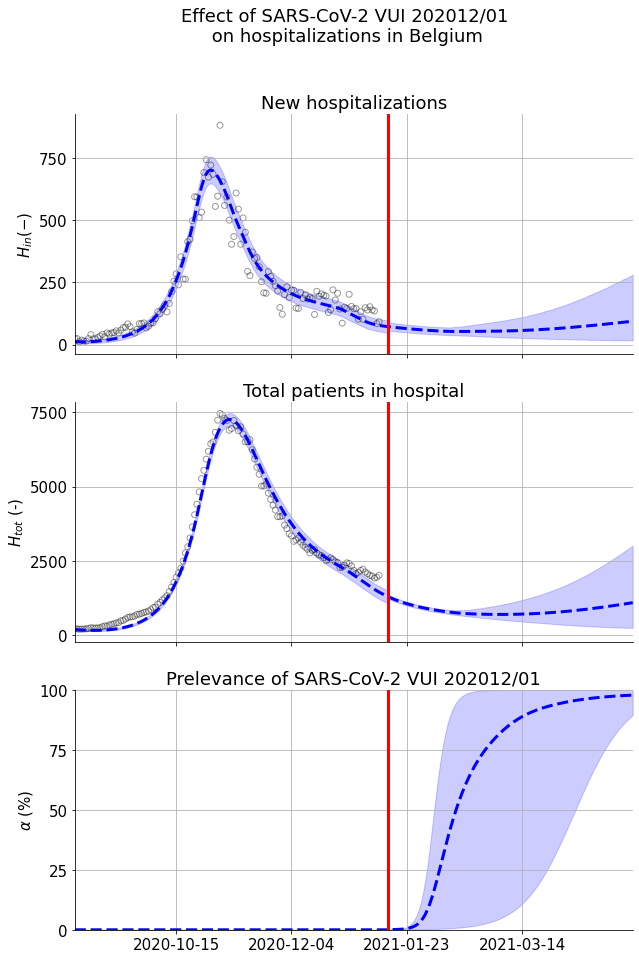

In [14]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1,ax2,ax3) = plt.subplots(3,sharex=True,figsize=(10,15))
# Incidence
ax1.fill_between(time,H_in_LL, H_in_UL,alpha=0.20, color = 'blue')
ax1.plot(time,H_in_mean,'--', color='blue')
ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
# Load
ax2.fill_between(time,H_tot_LL, H_tot_UL,alpha=0.20, color = 'blue')
ax2.plot(time,H_tot_mean,'--', color='blue')
ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
# British variant
ax3.plot(time,np.mean(alpha,axis=0)*100,'--', color='blue')
ax3.fill_between(time,np.quantile(alpha,UL,axis=0)*100, np.quantile(alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax1 = _apply_tick_locator(ax1)
ax2.set_title('Total patients in hospital')
ax2.set_ylabel('$H_{tot}$ (-)')
ax2.set_xlim('2020-09-01',end_sim2)
ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prelevance of SARS-CoV-2 VUI 202012/01')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
fig.suptitle('Effect of SARS-CoV-2 VUI 202012/01\n on hospitalizations in Belgium')
# Save
fig_path =  '../../results/predictions/national/restore_v7.0/'
fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.jpg', dpi=400, bbox_inches='tight')